# Notebook of comparison VAE and geometric VAE

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE, GeometricNBAE
from scCFM.models.base.geodesic_ae import GeodesicAE

from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata
import matplotlib.pyplot as plt

import scipy

import seaborn as sns
import matplotlib.pyplot as plt

Initialize terminal states

In [9]:
def make_joint_df(arrays, labels):
    all_arrays = np.concatenate(arrays)
    all_labels = []
    for i,lab in enumerate(labels):
        all_labels += [lab for _ in range(len(arrays[i]))]
    return pd.DataFrame({"values": all_arrays,
                         "labels": all_labels})

## Initialize the two different configurations 

General module hparams

In [10]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'leiden'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 512, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

### Model config VAE

In [18]:
model_vae={'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': False, 
       'batch_norm': True, 
       'hidden_dims': [512, 256, 10], 
       'library_size_regression': False, 
       'data_library_size': False, 
       'kl_warmup_fraction': 1}

model_geometric={'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': False, 
       'batch_norm': True, 
       'hidden_dims': [512, 256, 10], 
       'library_size_regression': False, 
       'data_library_size': False, 
       'kl_warmup_fraction': 1}

# model_geometric={'in_dim': datamodule.in_dim,
#        'kl_weight': None, 
#        'likelihood': 'nb', 
#        'dropout': False, 
#        'learning_rate': 0.001, 
#        'dropout_p': False, 
#        'model_library_size': False, 
#        'batch_norm': True, 
#        'hidden_dims': [256, 10], 
#        'library_size_regression': False, 
#        'data_library_size': False}
        
geometric={'compute_metrics_every': 1, 
                         'use_c': False,
                         'l2': True, 
                         'eta_interp': 0,
                         'interpolate_z': False, 
                         'fl_weight': 1, 
                         'detach_theta': False, 
                         'start_jac_after': 0}

In [19]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_geometric)

In [29]:
vae

GeometricNBVAE(
  (encoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1241, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (decoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=10, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
  

In [20]:
# vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)
# geometric_vae = GeometricNBAE(**geometric, vae_kwargs=model_geometric)

In [28]:
torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae.ckpt")["state_dict"]["theta"].shape

torch.Size([1241])

In [23]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geometric.ckpt")["state_dict"])

RuntimeError: Error(s) in loading state_dict for GeometricNBVAE:
	size mismatch for decoder_mu_lib.weight: copying a param with shape torch.Size([1242, 512]) from checkpoint, the shape in current model is torch.Size([1241, 512]).
	size mismatch for decoder_mu_lib.bias: copying a param with shape torch.Size([1242]) from checkpoint, the shape in current model is torch.Size([1241]).

In [ ]:
print("Correct theta: ", torch.exp(vae.theta))

In [ ]:
print("Incorrect theta: ", torch.exp(geometric_vae.theta))

### Compute UMAPs

In [ ]:
adata_vae_amortized_real, adata_vae_z, adata_vae_mu = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=True, log1p=True).values()
adata_geometric_amortized_real, adata_geometric_z, adata_geometric_mu = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=True, log1p=True, vae=True).values()

In [ ]:
adata_vae_z.obs["leiden"] = adata_vae_z.obs["leiden"].astype("category")
adata_geometric_z.obs["leiden"] = adata_geometric_z.obs["leiden"].astype("category")

Plot the UMAP results

In [ ]:
sc.pl.umap(adata_vae_z, color=["experimental_time", "leiden"])
sc.pl.umap(adata_geometric_z, color=["experimental_time", "leiden"])

In [ ]:
sc.pl.pca(adata_vae_z, color=["experimental_time", "leiden"], annotate_var_explained=True)
sc.pl.pca(adata_geometric_z, color=["experimental_time", "leiden"], annotate_var_explained=True)

In [ ]:
sc.pl.umap(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.umap(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])

In [ ]:
sc.pl.pca(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.pca(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])

Check reconstruction umap

In [90]:
from pytorch_lightning import Trainer

trainer_vae = Trainer(inference_mode=False)
trainer_geometric = Trainer(inference_mode=False)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-pa ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-pa ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

In [91]:
# trainer_vae.validate(model=vae, dataloaders=datamodule)

In [92]:
# trainer_geometric.validate(model=geometric_vae, 
#                        dataloaders=datamodule)

**Save anndata**

In [93]:
PROJECT_FOLDER / "data/eb/flat/"

PosixPath('/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat')

In [94]:
# adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
# adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/eb/flat/eb.h5ad")

In [95]:
# adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
# adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/eb/flat/eb_flat.h5ad")

In [96]:
annot = ["geometric" for _ in range(len(adata_geometric_z))] + ["normal" for _ in range(len(adata_vae_z))]
concat = anndata.concat([adata_geometric_z, adata_vae_z], merge="same")
concat.obs["dataset_type"] = annot

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


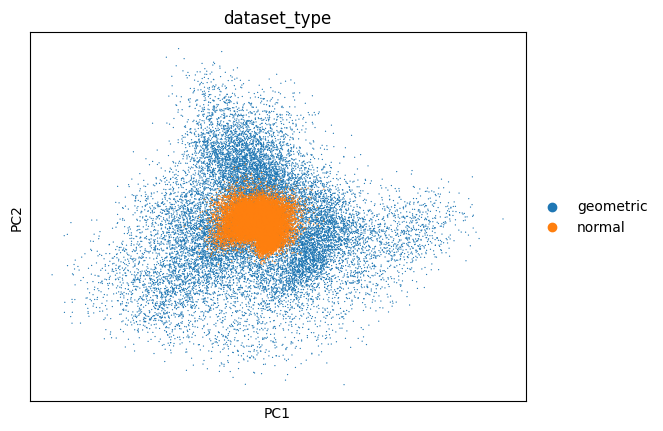

In [97]:
sc.tl.pca(concat)
sc.pl.pca(concat, color="dataset_type")

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


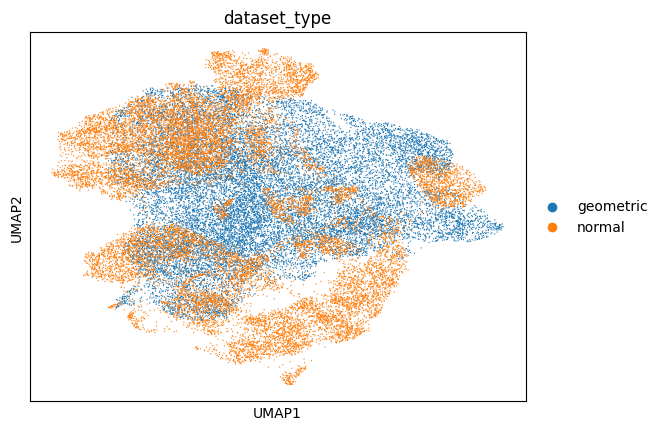

In [98]:
sc.pl.umap(concat, color="dataset_type")

**Check the latent sizes**

Geometric

In [1]:
adata_geometric_z.X.max()

NameError: name 'adata_geometric_z' is not defined

In [100]:
adata_geometric_z.X.min()

-14.042354

In [101]:
adata_geometric_z.X.mean()

0.027195334

In [102]:
adata_geometric_z.X.var()

4.820851

VAE

In [103]:
adata_vae_z.X.max()

5.2114396

In [104]:
adata_vae_z.X.min()

-5.126415

In [105]:
adata_vae_z.X.mean()

0.00042824974

In [106]:
adata_vae_z.X.var()

1.1141815

<Axes: xlabel='values', ylabel='Count'>

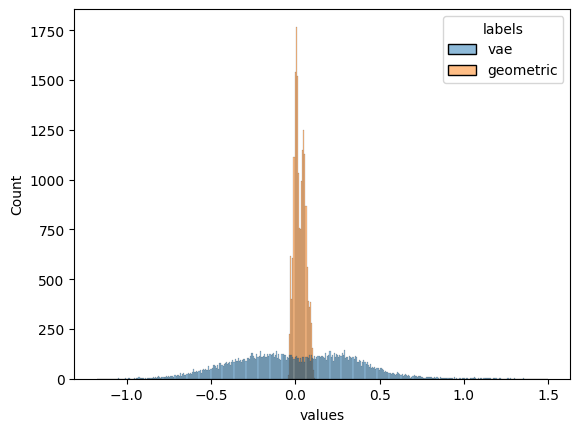

In [107]:
vae_mean_df = make_joint_df([adata_vae_z.X.mean(1), adata_geometric_z.X.mean(1)], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

## Compare real and generated data

In [108]:
adata_real = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="real"]
adata_generated_vae = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="generated_amortized"]
adata_generated_geometric = adata_geometric_amortized_real[adata_geometric_amortized_real.obs['dataset_type']=="generated_amortized"]

adata_real.layers["X_norm"] = np.exp(adata_real.X)-1
adata_generated_vae.layers["X_norm"] = np.exp(adata_generated_vae.X)-1
adata_generated_geometric.layers["X_norm"] = np.exp(adata_generated_geometric.X)-1

**Compare generated log**

<Axes: xlabel='values', ylabel='Count'>

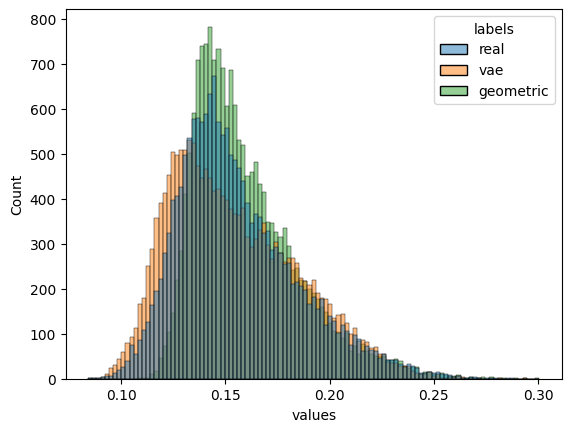

In [109]:
vae_mean_df = make_joint_df([adata_real.X.mean(1), 
                             adata_generated_vae.X.mean(1), 
                             adata_generated_geometric.X.mean(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

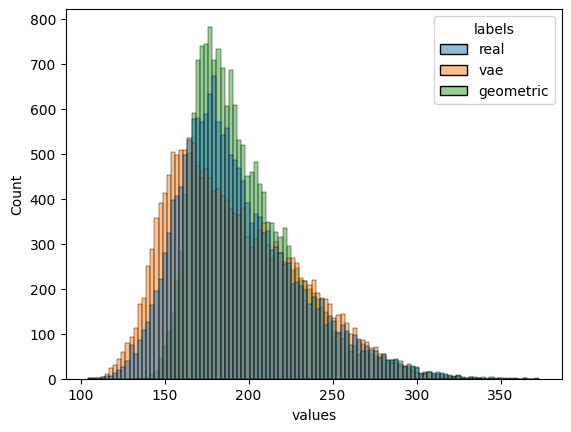

In [110]:
vae_mean_df = make_joint_df([adata_real.X.sum(1), 
                             adata_generated_vae.X.sum(1), 
                             adata_generated_geometric.X.sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

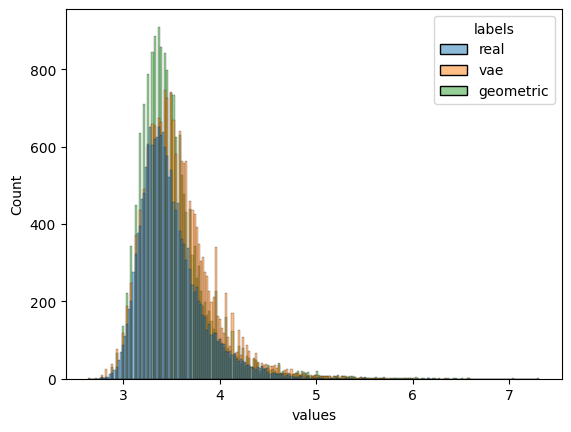

In [111]:
vae_mean_df = make_joint_df([adata_real.X.max(1), 
                             adata_generated_vae.X.max(1), 
                             adata_generated_geometric.X.max(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

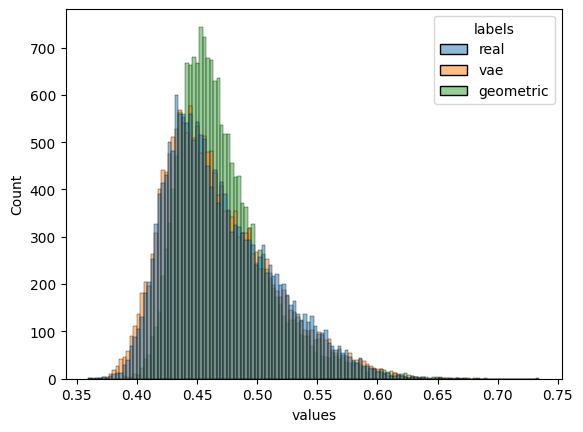

In [112]:
vae_mean_df = make_joint_df([adata_real.X.std(1), 
                             adata_generated_vae.X.std(1), 
                             adata_generated_geometric.X.std(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

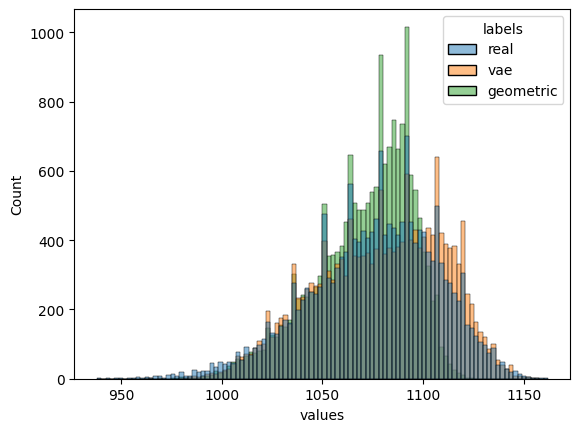

In [114]:
vae_mean_df = make_joint_df([(adata_real.X==0).sum(1), 
                             (adata_generated_vae.X==0).sum(1), 
                             (adata_generated_geometric.X==0).sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

**Compare inverse dispersions log**

<Axes: xlabel='values', ylabel='Count'>

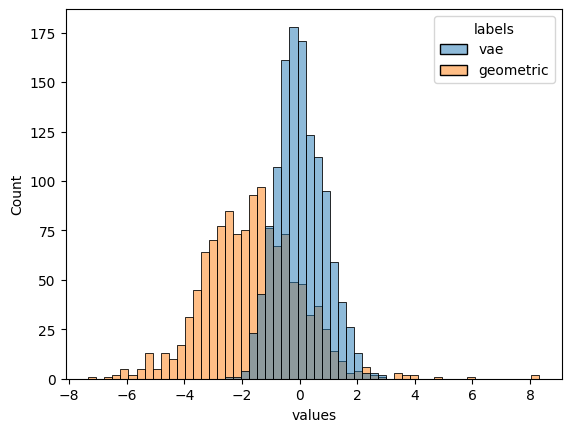

In [115]:
vae_mean_df = make_joint_df([vae.theta.detach().cpu().numpy(), 
                             geometric_vae.theta.detach().cpu().numpy()], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

**Check the means**

<Axes: xlabel='values', ylabel='Count'>

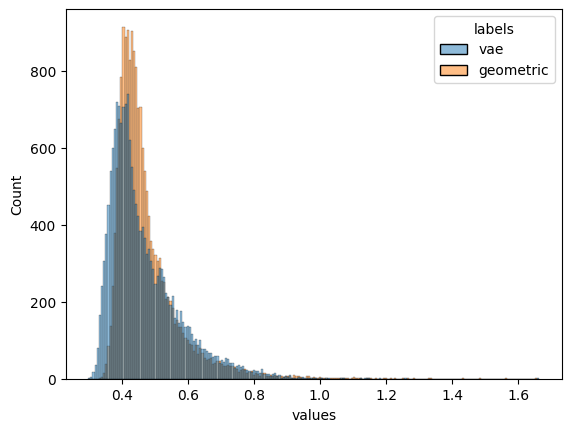

In [116]:
vae_mean_df = make_joint_df([np.exp(adata_vae_mu.X).mean(1), np.exp(adata_geometric_mu.X).mean(1)], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

In [ ]:
vae_mean_df = make_joint_df([np.exp(adata_vae_mu.X).max(1), np.exp(adata_geometric_mu.X).max(1)], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

In [ ]:
vae_mean_df = make_joint_df([np.exp(adata_vae_mu.X).min(1), np.exp(adata_geometric_mu.X).min(1)], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

**Compare inverse dispersions log**

<Axes: xlabel='values', ylabel='Count'>

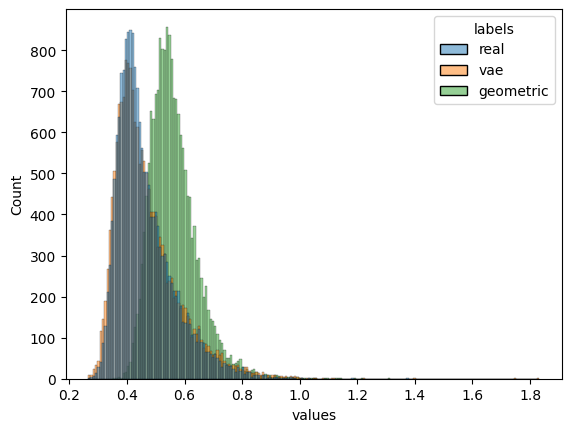

In [80]:
vae_mean_df = make_joint_df([adata_real.layers["X_norm"].mean(1), 
                             adata_generated_vae.layers["X_norm"].mean(1), 
                             adata_generated_geometric.layers["X_norm"].mean(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

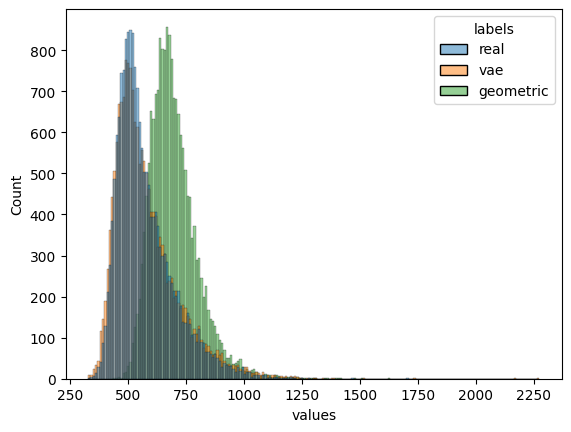

In [83]:
vae_mean_df = make_joint_df([adata_real.layers["X_norm"].sum(1), 
                             adata_generated_vae.layers["X_norm"].sum(1), 
                             adata_generated_geometric.layers["X_norm"].sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

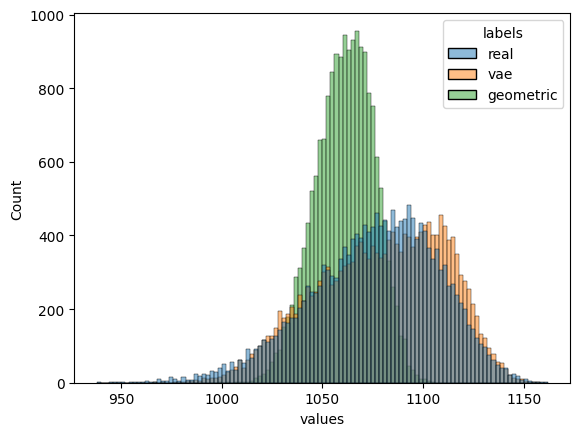

In [85]:
vae_mean_df = make_joint_df([(adata_real.layers["X_norm"]==0).sum(1), 
                             (adata_generated_vae.layers["X_norm"]==0).sum(1), 
                             (adata_generated_geometric.layers["X_norm"]==0).sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

**Mean variance plots**

In [90]:
mean_real = adata_real.layers["X_norm"].mean(0)
variance_real = adata_real.layers["X_norm"].var(0)

mean_vae = adata_generated_vae.layers["X_norm"].mean(0)
variance_vae = adata_generated_vae.layers["X_norm"].var(0)

mean_geometric = adata_generated_geometric.layers["X_norm"].mean(0)
variance_geometric = adata_generated_geometric.layers["X_norm"].var(0)

In [91]:
mean_real_log = adata_real.X.mean(0)
variance_real_log = adata_real.X.var(0)

mean_vae_log = adata_generated_vae.X.mean(0)
variance_vae_log = adata_generated_vae.X.var(0)

mean_geometric_log = adata_generated_geometric.X.mean(0)
variance_geometric_log = adata_generated_geometric.X.var(0)

In [92]:
adata_vae_amortized_real

AnnData object with n_obs × n_vars = 35840 × 1241
    obs: 'dataset_type', 'experimental_time', 'leiden'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'dataset_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

<Figure size 1000x600 with 0 Axes>

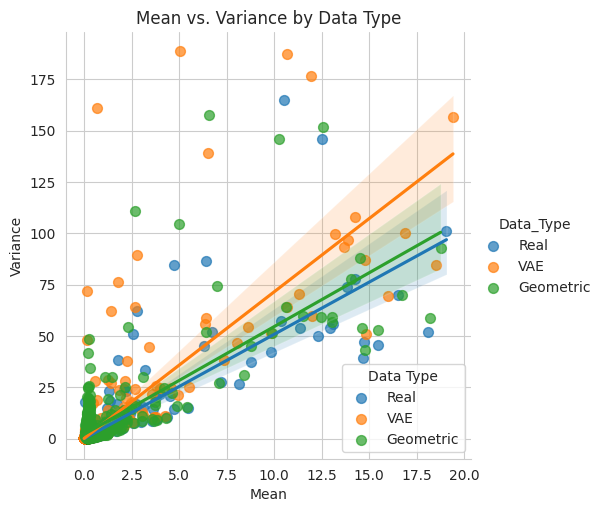

In [93]:
# Create a DataFrame with the data
data = pd.DataFrame({
    'Mean': np.concatenate([mean_real, mean_vae, mean_geometric]),
    'Variance': np.concatenate([variance_real, variance_vae, variance_geometric]),
    'Data_Type': ['Real'] * len(mean_real) + ['VAE'] * len(mean_vae) + ['Geometric'] * len(mean_geometric)
})

# Create a Seaborn regression plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.lmplot(data=data, x='Mean', y='Variance', hue='Data_Type',scatter_kws={'s': 50, 'alpha': 0.7})

# Customize the plot
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Mean vs. Variance by Data Type')

# Show the legend
plt.legend(title='Data Type')

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

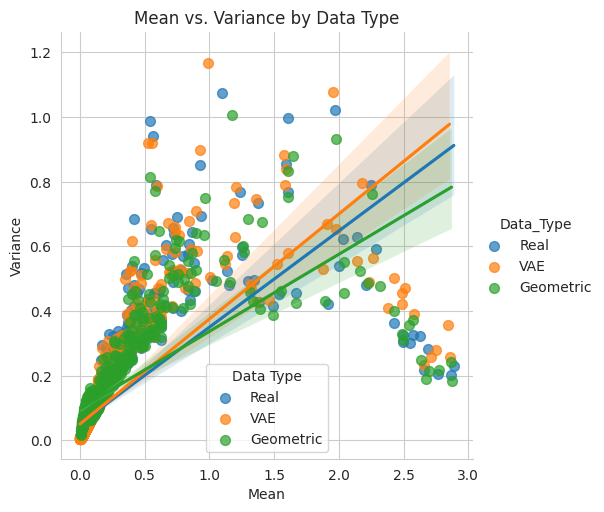

In [94]:
# Create a DataFrame with the data
data = pd.DataFrame({
    'Mean': np.concatenate([mean_real_log, mean_vae_log, mean_geometric_log]),
    'Variance': np.concatenate([variance_real_log, variance_vae_log, variance_geometric_log]),
    'Data_Type': ['Real'] * len(mean_real) + ['VAE'] * len(mean_vae) + ['Geometric'] * len(mean_geometric)
})

# Create a Seaborn regression plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.lmplot(data=data, x='Mean', y='Variance', hue='Data_Type',scatter_kws={'s': 50, 'alpha': 0.7})

# Customize the plot
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Mean vs. Variance by Data Type')

# Show the legend
plt.legend(title='Data Type')

# Show the plot
plt.show()